In [1]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
import os
import tqdm
from tqdm import tqdm
import tqdm
import numpy as np
from functools import partial
import json
# changed activation function to hyperbolic tangent
import tensorflow as tf
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE
from dask.diagnostics import ProgressBar
import pandas as pd
import sys
sys.path.append(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling')
from src.layers import *
from src.models import *
from src.gan import *
from ops.model_inference.src_eval_inference import *
config_file = r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling/models/Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.005/config_info.json'



In [2]:
with open(config_file, 'r') as f:
    config = json.load(f)

In [3]:
generator = tf.keras.models.load_model(f'{config["output_folder"]}/{config["model_name"]}/generator_final.h5',
                            custom_objects={"BicubicUpSampling2D": BicubicUpSampling2D,
                                            "SymmetricPadding2D": SymmetricPadding2D},
                            compile=False)
unet_model = tf.keras.models.load_model(f'{config["output_folder"]}/{config["model_name"]}/unet_final.h5',
                                    custom_objects={"BicubicUpSampling2D": BicubicUpSampling2D,
                                                    "SymmetricPadding2D": SymmetricPadding2D}, compile=False)

d_model = tf.keras.models.load_model(f'{config["output_folder"]}/{config["model_name"]}/discriminator_final.h5',
                                    custom_objects={"BicubicUpSampling2D": BicubicUpSampling2D,
                                                    "SymmetricPadding2D": SymmetricPadding2D}, compile=False)

In [295]:



# y['tasmin'] = (y['tasmin'] - output_means['tasmin'])/output_stds['tasmin']
# min_value = y.tasmin.min()
# y['tasmin'] = y['tasmin'] - min_value

os.chdir(r'/nesi/project/niwa00018/ML_downscaling_CCAM/A-Robust-Generative-Adversarial-Network-Approach-for-Climate-Downscaling')

with open(config_file) as f:
    config = json.load(f)
quantiles = [ 0.5 , 0.7, 0.9, 0.925,
             0.95, 0.975, 0.98, 0.99,
             0.995, 0.998, 0.999]
historical_period = slice("2004","2004-06-01")
future_period = slice("2070","2099")
config["means_output"] = "/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/target_spatial_norm_all_gcm_mean.nc"
config["stds_output"] = "/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/target_spatial_norm_all_gcm_std.nc"
output_means = xr.open_dataset(config["means_output"])
output_stds = xr.open_dataset(config["stds_output"])


config["train_x"] ="/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/predictor_fields/predictor_fields_hist_ssp370_merged_updated.nc"
config["train_y"] = "/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc"
stacked_X, y, vegt, orog, he = preprocess_input_data(config, match_index =False)

gan, unet, adv_factor = load_model_cascade(config["model_name"], None, './models', load_unet=True)

<xarray.DataArray 'orog' ()>
array(1733.36035156) <xarray.DataArray 'he' ()>
array(1157.46264648) <xarray.DataArray 'vegt' ()>
array(17.00000763)


In [297]:
gcm = ['NorESM2-MM']
try:
    y = y.sel(GCM =gcm[0])[['pr']]
except:
    y =y[['pr']]

In [216]:
n_members =10

In [220]:
experiments_no_iten = ['Reviewer_Historical_ACCESS-CM2_0.01',
               'Reviewer_Historical_ACCESS-CM2_0.0001',
               'Reviewer_Historical_ACCESS-CM2_0.001',
               'Reviewer_Historical_ACCESS-CM2_0.0025',
               'Reviewer_Historical_ACCESS-CM2_0.005',
               'Reviewer_Historical_ACCESS-CM2_0.01',
               'Reviewer_Historical_ACCESS-CM2_0.1',
               ]

experiments_no_iten = [
               'Reviewer_Historical_ACCESS-CM2_0.005',
               'Reviewer_Historical_ACCESS-CM2_0.0001',
               'Reviewer_Historical_ACCESS-CM2_0.01',
               'Reviewer_Historical_ACCESS-CM2_0.1',
               ]
fields = []
lam = []
for gcm in ['NorESM2-MM']:
    for i, experiment in enumerate(experiments_no_iten):
        gan, unet, lambdas = load_model_cascade(experiment, None, './models', load_unet=True)
        if i == 0:
            # first instance is always a unet model
            lambdas = 0.0
            print(f"prepraring data fpr a GCM {gcm}")
            output_shape = create_output(stacked_X, y)
            output_shape.pr.values = output_shape.pr.values * 0.0
            preds = xr.concat([predict_parallel_resid(gan, unet,
                                        stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
                                        output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values, model_type='UNET') for i in range(n_members)], dim ="member")
        else:
            output_shape = create_output(stacked_X, y)
            output_shape.pr.values = output_shape.pr.values * 0.0
            preds = xr.concat([predict_parallel_resid(gan, unet,
                                        stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
                                        output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values, model_type='GAN') for i in range(n_members)], dim ="member")
        fields.append(preds)
        lam.append(lambdas)
fields = xr.concat(fields, dim ="experiment")
fields['experiment'] = (('experiment'), lam)

prepraring data fpr a GCM NorESM2-MM


Predicting: 100%|██████████| 5/5 [00:03<00:00,  1.51batch/s]


In [319]:
experiments_iten = ['Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.01',
               'Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.0001',
               'Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.001',
               'Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.0025',
               'Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.005',
               'Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.01',
               'Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.1',
               ]
experiments_iten = ['Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.001',
                    'Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.0001',
               'Reviewer_Historical_Intensity_Max_ACCESS-CM2_0.1',
               ]
fields_iten = []
lam_iten = []
for gcm in ['NorESM2-MM']:
    for i, experiment in enumerate(experiments_iten):
        gan, unet, lambdas = load_model_cascade(experiment, None, './models', load_unet=True)
        if i == 0:
            # first instance is always a unet model
            lambdas = 0.0
            print(f"prepraring data fpr a GCM {gcm}")
            output_shape = create_output(stacked_X, y)
            output_shape.pr.values = output_shape.pr.values * 0.0
            preds = xr.concat([predict_parallel_resid(gan, unet,
                                        stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
                                        output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values, model_type='UNET') for i in range(10)], dim ="member")
        else:
            output_shape = create_output(stacked_X, y)
            output_shape.pr.values = output_shape.pr.values * 0.0
            preds = xr.concat([predict_parallel_resid(gan, unet,
                                        stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
                                        output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values, model_type='GAN') for i in range(10)], dim ="member")
        fields_iten.append(preds)
        lam_iten.append(lambdas)
fields_iten = xr.concat(fields_iten, dim ="experiment")
fields_iten['experiment'] = (('experiment'), lam_iten)

prepraring data fpr a GCM NorESM2-MM


Predicting: 100%|██████████| 2/2 [00:01<00:00,  1.54batch/s]


In [103]:
import cmocean

In [164]:
mse = abs(fields_iten.mean("member") - y.sel(time = fields_iten.time)*3600*24)**2

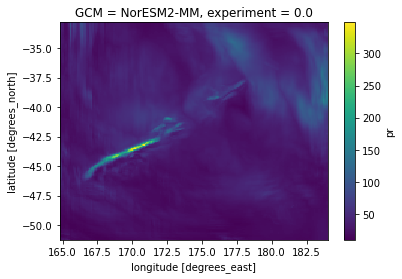

In [252]:
fields_iten.sel(experiment =0.000).max("time").isel(member =2).pr.plot()

In [247]:
fields.isel(time =0).pr

<xarray.DataArray 'pr' (experiment: 4, member: 10, lat: 172, lon: 179)>
array([[[[3.35992962e-01, 3.42996895e-01, 3.27606112e-01, ...,
          1.17252433e+00, 1.18882895e+00, 1.17369497e+00],
         [3.25743407e-01, 3.37254375e-01, 3.37150127e-01, ...,
          1.11089563e+00, 1.12278545e+00, 1.09400940e+00],
         [3.07835609e-01, 3.35799962e-01, 3.50267053e-01, ...,
          1.12847793e+00, 1.15613163e+00, 1.12417185e+00],
         ...,
         [3.44089642e-02, 2.82958057e-02, 3.16520259e-02, ...,
          6.54965544e+00, 5.00421000e+00, 3.59763288e+00],
         [3.52803320e-02, 2.89866794e-02, 3.34934592e-02, ...,
          6.46404409e+00, 4.74355507e+00, 3.29044890e+00],
         [3.85151729e-02, 3.13623399e-02, 3.52838039e-02, ...,
          6.33838129e+00, 4.59668398e+00, 2.94467187e+00]],

        [[3.35992962e-01, 3.42996895e-01, 3.27606112e-01, ...,
          1.17252433e+00, 1.18882895e+00, 1.17369497e+00],
         [3.25743407e-01, 3.37254375e-01, 3.37150127e-01, ...,
          1.11089563e+00, 1.12278545e+00, 1.09400940e+00],
         [3.07835609e-01, 3.35799962e-01, 3.50267053e-01, ...,
          1.12847793e+00, 1.15613163e+00, 1.12417185e+00],
...
         [2.91363504e-02, 2.91267950e-02, 2.79821064e-02, ...,
          8.09934235e+00, 6.57327843e+00, 6.33876038e+00],
         [9.35375132e-03, 9.87807289e-03, 8.89066979e-03, ...,
          6.69748974e+00, 5.38081789e+00, 5.23521376e+00],
         [6.02397323e-03, 6.62119687e-03, 6.17900863e-03, ...,
          5.26800585e+00, 4.65782785e+00, 4.38217354e+00]],

        [[1.79481149e-01, 1.62211388e-01, 1.52751043e-01, ...,
          5.20008385e-01, 5.31887114e-01, 5.39245188e-01],
         [5.96293628e-01, 5.72371006e-01, 5.61750650e-01, ...,
          4.34554398e-01, 4.29009855e-01, 4.37899232e-01],
         [7.12382674e-01, 5.89343011e-01, 5.22922873e-01, ...,
          4.34213102e-01, 4.33151394e-01, 4.35281366e-01],
         ...,
         [2.78517883e-02, 3.06740720e-02, 3.07261478e-02, ...,
          8.14442539e+00, 3.28898811e+00, 2.44847465e+00],
         [6.05587475e-03, 8.08477588e-03, 8.75860825e-03, ...,
          7.96381330e+00, 3.19263101e+00, 2.02116203e+00],
         [2.84681842e-03, 5.41324168e-03, 6.59684651e-03, ...,
          8.68659306e+00, 3.73661637e+00, 1.94174004e+00]]]])
Coordinates:
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM         <U10 'NorESM2-MM'
    time        datetime64[ns] 2014-01-01
  * experiment  (experiment) float64 0.0 0.0001 0.01 0.1
Dimensions without coordinates: member
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    units:          kg m-2 s-1
    cell_methods:   time: mean

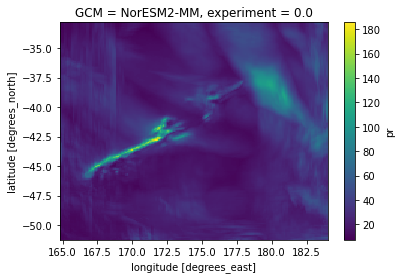

In [299]:
fields_iten.sel(experiment =0.000).max("time").isel(member =0).pr.plot()

In [289]:
df2 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/Intensity_Penalty/NorESM2-MM_Intensity_Penalty_hist_1986_2005_cascaded_perfect_applied.nc')

In [320]:
z = df2.sel(time = fields_iten.time.to_index().intersection(df2.time.to_index())).isel(experiment =-1).mean("member").mean("time")#.pr.plot(vmax =7, cmap ='BrBG')

In [321]:
abs(z - (y.sel(time = fields_iten.time.to_index().intersection(df2.time.to_index()))*86400).mean("time")).mean()


<xarray.Dataset>
Dimensions:     ()
Coordinates:
    experiment  float64 0.1
    GCM         <U10 'NorESM2-MM'
Data variables:
    pr          float64 0.408

In [324]:
abs(fields_iten.sel(time = fields_iten.time.to_index().intersection(df2.time.to_index())).sel(experiment =0.0001).mean("time").mean("member") - (y.sel(time = fields_iten.time.to_index().intersection(df2.time.to_index()))*86400).mean("time")).mean()

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    GCM         <U10 'NorESM2-MM'
    experiment  float64 0.0001
Data variables:
    pr          float64 1.032

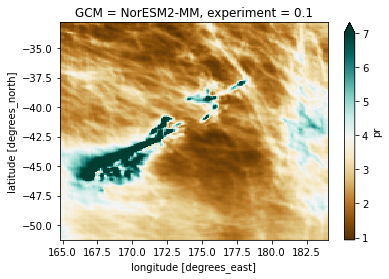

In [311]:
fields_iten.sel(time = fields_iten.time.to_index().intersection(df2.time.to_index())).sel(experiment =0.1).mean("time").mean("member").pr.plot(vmax =7, cmap ='BrBG')

In [ ]:
fields_iten.sel(experiment =0.0001).max("time").mean("member").pr.plot()

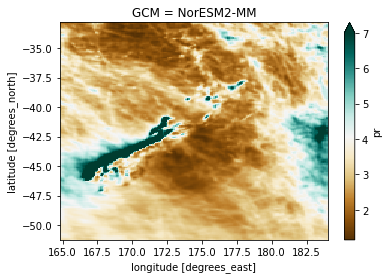

In [312]:
(y.sel(time = fields_iten.time.to_index().intersection(df2.time.to_index()))*86400).mean("time").pr.plot(vmax =7, cmap ='BrBG')

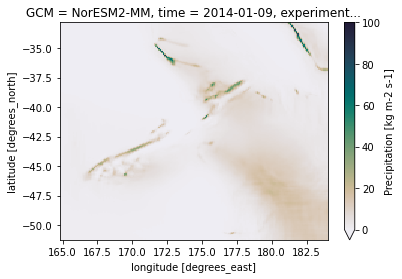

In [237]:
fields_iten.sel(experiment =0.0001).isel(time = 8).isel(member =2).pr.plot(cmap ='cmo.rain', vmax =100, vmin =0)

In [202]:
fields_iten.var("member").mean(["time","lat","lon"])

<xarray.Dataset>
Dimensions:     (experiment: 3)
Coordinates:
    GCM         <U10 'NorESM2-MM'
  * experiment  (experiment) float64 0.0 0.0001 0.1
Data variables:
    pr          (experiment) float64 0.0 0.2815 15.83

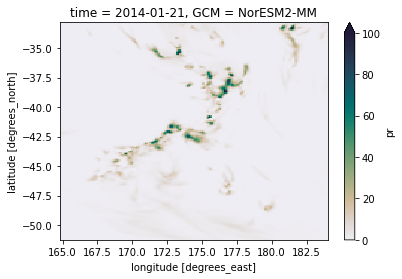

In [160]:
(y.sel(time = fields_iten.time)*86400).isel(time =20).pr.plot(cmap ='cmo.rain', vmax =100, vmin =0)

In [ ]:
# issue with the 0.0001 case predicting too large values - some instability of the adversarial loss

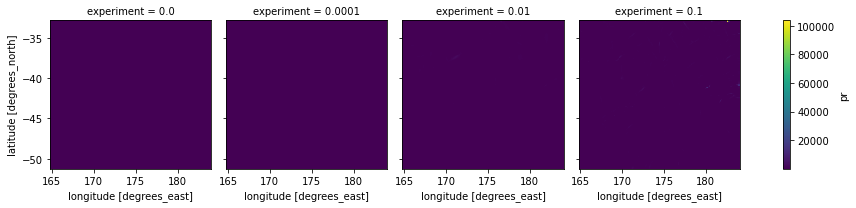

In [222]:
fields.isel(member =0).max("time").pr.plot(col ="experiment")

0.0
0.0001
0.01
0.1


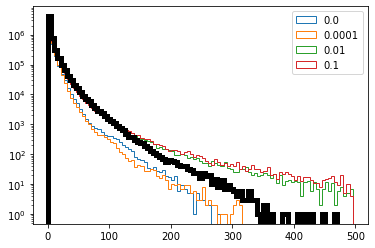

In [238]:
fig, ax = plt.subplots()
for i in fields.experiment.values:
    print(i)
    bins = np.arange(0.5, 500, 5)
    #plt.hist(output_hist_v2.isel( member =1).pr.values.ravel(), histtype='step', bins = bins)
    #plt.hist(output_hist_v3.isel( member =1).pr.values.ravel(), histtype='step', bins = bins)
    ax.hist(fields.isel(member =0).where(fields.isel(member =0).pr>0, np.nan).sel(experiment = i).pr.stack(z=['time','lat','lon']).dropna("z").values.ravel(), 
            histtype='step', bins = bins, label =f'{i}')
ax.hist((y.sel(time = fields.time)*3600*24).pr.values.ravel(), histtype='step', bins = bins, color ='k', lw =5)
    
ax.set_yscale('log')
ax.legend()
fig.show()

0.0
0.0001
0.1


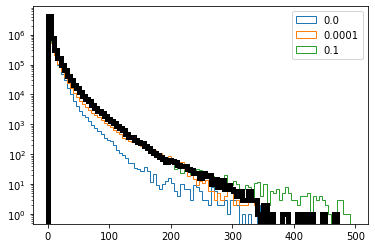

In [254]:
fig, ax = plt.subplots()
for i in fields_iten.experiment.values:
    print(i)
    bins = np.arange(0.5, 500, 5)
    #plt.hist(output_hist_v2.isel( member =1).pr.values.ravel(), histtype='step', bins = bins)
    #plt.hist(output_hist_v3.isel( member =1).pr.values.ravel(), histtype='step', bins = bins)
    ax.hist(fields_iten.isel(member =0).where(fields_iten.isel(member =1).pr>0, np.nan).sel(experiment = i).pr.stack(z=['time','lat','lon']).dropna("z").values.ravel(), 
            histtype='step', bins = bins, label =f'{i}')
ax.hist((y.sel(time = fields.time)*3600*24).pr.values.ravel(), histtype='step', bins = bins, color ='k', lw =5)
    
ax.set_yscale('log')
ax.legend()
fig.show()

In [ ]:
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_dd

def psd(y, bins=np.arange(0, 0.52, 0.02)):
    """
    Compute Power Spectral Density (PSD) of an image y.

    Args:
    - y: Input image with shape (time, lat, lon).
    - bins: Array of bin edges for binning the wavenumbers.

    Returns:
    - psd_array: Array of PSD values with shape (time, K), where K is sqrt(kx^2 + ky^2),
                 representing the wavenumber in X and Y.

    - bin_edges: Bin edges used for binning the wavenumbers.
    """
    # Compute 2D FFT of the input image
    ffts = np.fft.fft2(y)
    ffts = np.fft.fftshift(abs(ffts) ** 2)

    # Compute the frequency grids
    freq = np.fft.fftshift(np.fft.fftfreq(172))
    freq2 = np.fft.fftshift(np.fft.fftfreq(179))
    kx, ky = np.meshgrid(freq, freq2)
    kx = kx.T
    ky = ky.T

    # Compute PSD by binning wavenumbers
    x = [
        binned_statistic(
            np.sqrt(kx.ravel() ** 2 + ky.ravel() ** 2),
            values=np.vstack(ffts[i].ravel()).T,
            statistic="mean",
            bins=bins,
        ).statistic
        for i in range(ffts.shape[0])
    ]

    # Compute PSD for the last time step (for normalization)
    x2 = binned_statistic(
        np.sqrt(kx.ravel() ** 2 + ky.ravel() ** 2),
        values=np.vstack(ffts[-1].ravel()).T,
        statistic="mean",
        bins=bins,
    )

    # Normalize the PSD and return it along with bin edges
    return np.array(x)[:, 0, :] / abs(x2.bin_edges[0] - x2.bin_edges[1]), x2.bin_edges

In [ ]:
# need to calcualte the true and the error in the powe spectral density. 

In [ ]:
spatial_av = concat_dsets_cat.isel(experiment =-1).mean(["lat","lon"])
times = spatial_av.where(spatial_av >8,np.nan).dropna("time").time[:-1]

In [ ]:
xs = []
for i, lambda_var in enumerate(concat_dsets_cat.experiment.values):
    x1, y1 = psd((concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).pr.values - concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).pr.mean("time").values)/concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).pr.std("time").values)
    xs.append(x1)




In [ ]:

cmap = plt.cm.RdBu
marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors representing "dry" and "wet"

minimum_freq_in_ccam = 12.5
fig, ax = plt.subplots(figsize = (8, 6))
for i,lambdas_var in enumerate(concat_dsets_cat.experiment.values):
    if lambdas_var == "Ground Truth":
        ax.loglog(y1[1:]/minimum_freq_in_ccam, np.mean(xs[i], axis =0), color='k', lw=5, label='CCAM', ls ='--')
    else:
        # if i%2==0:
        # #color_str = "#{:02x}{:02x}{:02x}".format(*color_gradient[i])
        #     ax.loglog(y1[1:]/minimum_freq_in_ccam, np.mean(xs[i], axis =0),label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = cmap(i*50), ls ='--')
        ax.loglog(y1[1:]/minimum_freq_in_ccam, np.mean(xs[i], axis =0),label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = colors_hist[i], ls ='-', 
                  marker =marker_types[i], alpha =0.6, lw =2)

        #ax.axvline(max_values.sel(experiment = lambdas_var).pr.values, color  = color_str)
reciprocal_ticks = [25, 50, 100, 500]

# Compute frequency values from reciprocal values
frequency_ticks = [1 / tick for tick in reciprocal_ticks]

# Add vertical dashed lines at specified frequencies
[ax.axvline(frequency_ticks[i], color='k', ls='--', alpha=0.3) for i in range(len(frequency_ticks))]

# Add a legend
ax.legend(fontsize=12)

# Set the y-axis label and font properties
ax.set_ylabel('Power Spectral Density', weight='bold', fontsize=15)

# Set the x-axis label and font properties
ax.set_xlabel('Spatial Wavelength', weight='bold', fontsize=15)

# Convert frequency_ticks to strings with the desired format
frequency_labels = [f'$\\frac{{1}}{{{int(1/tick)}}}$ km' if int(1/tick) > 1 else '1 km' for tick in frequency_ticks]

# Set the x-axis ticks and labels
plt.xticks(frequency_ticks, frequency_labels)

# Add any other desired labels, titles, legends, etc.

# Show the plot
plt.show()
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/psd_plot_norm_intensity_constraint.png', dpi =500, bbox_inches ='tight')
# a

In [8]:
dsets_lr = fields
rmse_lr = np.sqrt(abs(dsets_lr.sel(time = dsets_lr.time).mean("member") - y.sel(time = dsets_lr.time)*3600*24)**2)
rmss_lr = np.sqrt((abs(dsets_lr.sel(time = dsets_lr.time).mean("member") - dsets_lr.sel(time = dsets_lr.time))**2).mean("member"))

with ProgressBar():
    rmse_lr = rmse_lr.load()
    rmss_lr = rmss_lr.load()

In [50]:
dsets_lr = fields_iten
rmse_lr_ic = np.sqrt(abs(dsets_lr.sel(time = dsets_lr.time).clip(0,500).mean("member") - y.sel(time = dsets_lr.time)*3600*24)**2)
rmss_lr_ic = np.sqrt((abs(dsets_lr.sel(time = dsets_lr.time).clip(0,500).mean("member") - dsets_lr.sel(time = dsets_lr.time).clip(0,500))**2).mean("member"))

with ProgressBar():
    rmse_lr_ic = rmse_lr_ic.load()
    rmss_lr_ic = rmss_lr_ic.load()

In [10]:
cmap = plt.cm.RdBu
marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]


In [21]:
colors

[(0.403921568627451, 0.0, 0.12156862745098039, 1.0),
 (0.5192618223760093, 0.03690888119953864, 0.1400230680507497, 1.0),
 (0.6461361014994232, 0.07750865051903114, 0.16032295271049596, 1.0),
 (0.7340253748558246, 0.16608996539792387, 0.20261437908496732, 1.0),
 (0.7893886966551327, 0.2768166089965398, 0.2549019607843137, 1.0),
 (0.8484429065743945, 0.39769319492502875, 0.31826220684352163, 1.0),
 (0.8991926182237601, 0.5144175317185697, 0.4079200307574009, 1.0),
 (0.9453287197231833, 0.6205305651672431, 0.48942714340638194, 1.0),
 (0.9686274509803922, 0.7176470588235293, 0.5999999999999999, 1.0),
 (0.9838523644752019, 0.8089965397923875, 0.7167243367935409, 1.0),
 (0.9884659746251442, 0.8760476739715493, 0.809919261822376, 1.0),
 (0.9783160322952711, 0.9234140715109573, 0.891118800461361, 1.0),
 (0.9657054978854287, 0.9672433679354094, 0.9680891964628989, 1.0),
 (0.9072664359861592, 0.9395617070357555, 0.9573241061130334, 1.0),
 (0.8429834678969628, 0.9091118800461362, 0.9454825067281

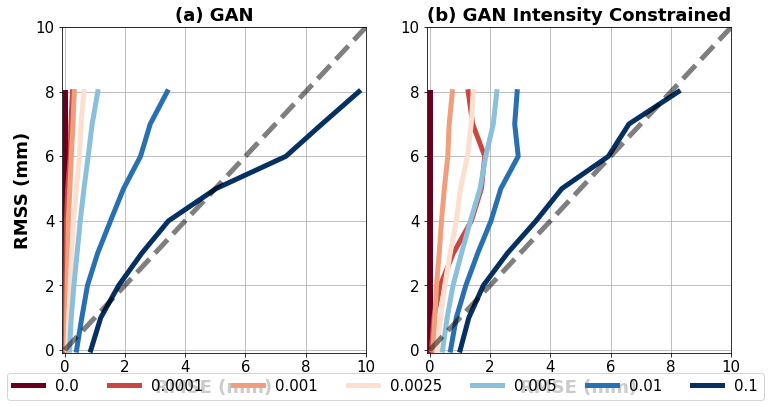

In [51]:




from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (12, 6))
factor = (25)/(25+1)
factor2 = (25)/(25-1)
bins =np.arange(0,10,1)
for i in range(7):
    x1 = binned_statistic(values=factor2 * rmss_lr.isel(experiment =i).mean("time").pr.values.ravel(), x=factor*rmse_lr.isel(experiment =i).mean("time").pr.values.ravel(),  statistic ='mean', bins =bins)
    #print(f"spread-ratio:{np.mean((1.11 * rmss_lr.isel(experiment =i).pr.values.ravel())/(0.9* rmse_lr.isel(experiment =i).pr.values.ravel()))}")
    ax[0].plot(x1[0], bins[:-1], label ='$\lambda_{adv}$=' +f'{rmse_lr.experiment.values[i]}', color = colors_hist[i], lw =5)
    x1 = binned_statistic(values=factor2 * rmss_lr_ic.isel(experiment =i).mean("time").pr.values.ravel(), x=factor*rmse_lr_ic.isel(experiment =i).mean("time").pr.values.ravel(),  statistic ='mean', bins =bins)
    #print(f"spread-ratio:{np.mean((1.11 * rmss_lr.isel(experiment =i).pr.values.ravel())/(0.9* rmse_lr.isel(experiment =i).pr.values.ravel()))}")
    ax[1].plot(x1[0], bins[:-1], label ='$\lambda_{adv}$=' +f'{rmse_lr.experiment.values[i]}', color = colors_hist[i], lw =5)
    #ax[1].scatter(x1[0], bins[:-1], color = colors_hist[i], marker = marker_types[i], s=35)

ax[0].plot([0,15], [0,15], ls ='--', color ='k', lw =5,alpha =0.5)
ax[0].grid('on')

ax[1].plot([0,15], [0,15], ls ='--', color ='k', lw =5,alpha =0.5)
ax[1].grid('on')


ax[0].set_xlim(-0.1, 10)
ax[0].set_ylim(-0.1,10)
ax[1].set_xlim(-0.1, 10)
ax[1].set_ylim(-0.1,10)

ax[0].set_xlabel('RMSE (mm)', fontsize=18, weight ='bold')
ax[1].set_xlabel('RMSE (mm)', fontsize=18, weight ='bold')
ax[0].set_ylabel('RMSS (mm)', fontsize=18, weight ='bold')
#ax[1].set_xlabel('RMSE (mm)', fontsize=18, weight ='bold')

ax[0].set_title('(a) GAN', weight ='bold', fontsize =18)
ax[1].set_title('(b) GAN Intensity Constrained', weight ='bold', fontsize =18)
ax[0].tick_params(labelsize =15)
ax[1].tick_params(labelsize =15)

#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/dispersion_relationship_9_4_24.png', dpi =700, bbox_inches ='tight')
#ax4 = fig.add_axes([0.1, 0.1, 0.5, 0.1])
fig.legend(labels=rmse_lr.experiment.values, loc='lower center', ncol=7, fontsize =15)



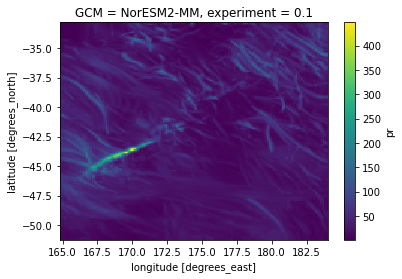

In [19]:
fields_iten.max("time").isel(experiment =1, member =0).pr.plot()

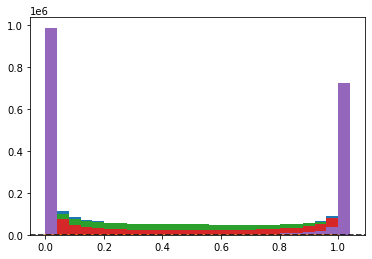

In [80]:
rank = (fields.isel(experiment =-1).where(fields.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs = outputs/ (rank.lat.size * rank.lon.size * rank.time.size)


plt.plot(bins[:-1], outputs)
plt.axhline(0.04, color ='k', ls ='--')

rank = (fields_iten.isel(experiment =-1).where(fields_iten.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs2, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs2 = outputs2/ (rank.lat.size * rank.lon.size * rank.time.size)

rank = (fields.isel(experiment =-2).where(fields.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs3, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs3 = outputs3/ (rank.lat.size * rank.lon.size * rank.time.size)

rank = (fields.isel(experiment =-3).where(fields.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs4, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs4 = outputs4/ (rank.lat.size * rank.lon.size * rank.time.size)

In [87]:
plt.plot(bins[:-1], outputs)
plt.plot(bins[:-1], outputs3, color ='r')
plt.plot(bins[:-1], outputs4, color ='green')

<xarray.Dataset>
Dimensions:     (time: 51100, GCM: 5, bnds: 2, lon: 179, lat: 172)
Coordinates:
  * time        (time) datetime64[ns] 1960-01-01 1960-01-02 ... 2099-12-31
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
  * GCM         (GCM) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (GCM, time, bnds) object 1960-01-01 00:30:00 ... 2099-12-31 2...
    pr          (GCM, time, lat, lon) float32 ...
    psl         (GCM, time, lat, lon) float32 ...
    sfcWind     (GCM, time, lat, lon) float32 ...
    sfcWindmax  (GCM, time, lat, lon) float32 ...
    tasmax      (GCM, time, lat, lon) float32 ...
    tasmin      (GCM, time, lat, lon) float32 ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [91]:
true_quantile =  (y.sel(time = fields_iten.time)*3600*24).where(y.sel(time = fields_iten.time)*3600*24>0, np.nan).quantile(q = 0.99, dim ="time")
rank = (fields.isel(experiment =-1).where(fields.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
rank = rank.where(y.sel(time = fields_iten.time)*3600*24 > true_quantile, np.nan)


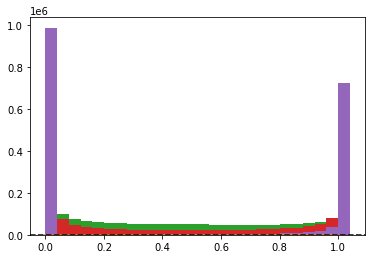

In [92]:
rank = (fields.isel(experiment =-1).where(fields.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
rank = rank.where(y.sel(time = fields_iten.time)*3600*24 > true_quantile, np.nan)

# computing the rank on the most extreme events


outputs, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs = outputs/ (rank.lat.size * rank.lon.size * rank.time.size)


plt.plot(bins[:-1], outputs)
plt.axhline(0.04, color ='k', ls ='--')

rank = (fields_iten.isel(experiment =-1).where(fields_iten.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs2, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs2 = outputs2/ (rank.lat.size * rank.lon.size * rank.time.size)

rank = (fields.isel(experiment =-2).where(fields.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs3, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs3 = outputs3/ (rank.lat.size * rank.lon.size * rank.time.size)

rank = (fields.isel(experiment =-3).where(fields.isel(experiment =-1)>0.001, 0.0).clip(0,1000) > y.sel(time = fields_iten.time)*3600*24).sum("member")/25.0
outputs4, bins, arrays = plt.hist(rank.pr.values.ravel(), bins = np.arange(0.00,1.05, 0.04))

outputs4 = outputs4/ (rank.lat.size * rank.lon.size * rank.time.size)

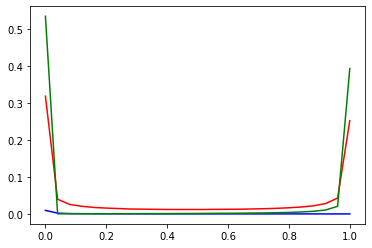

In [95]:
plt.plot(bins[:-1], outputs, color ='b')
plt.plot(bins[:-1], outputs3, color ='r')
plt.plot(bins[:-1], outputs4, color ='green')

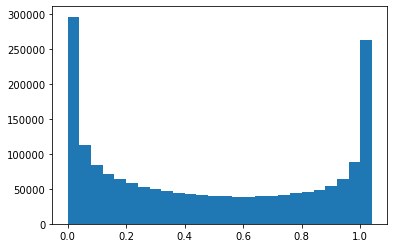

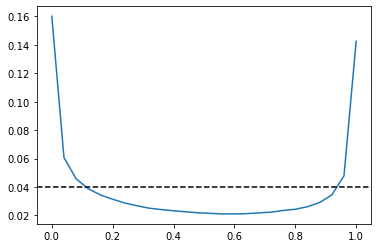

In [17]:
import numpy as np
import numba

# Example data setup
# Assuming quants, fields_iten, and y are provided as xarray DataArrays


quantile_bins = np.arange(0, 1.05, 0.05)

@numba.jit(nopython=True)
def calculate_quantile_subset(fields_iten, y):
    comparison_count = []
    for lat in range(fields_iten.shape[1]):
        for lon in range(fields_iten.shape[2]):
            for time in range(fields_iten.shape[3]):
                count = 0
                for member in range(fields_iten.shape[0]):
                    count += (fields_iten[member, time, lat, lon] > y[time, lat, lon])
                comparison_count.append(count)
    return comparison_count

# @numba.jit(nopython=True)
# def calculate_quantile_subset(fields_iten, y):
#     comparison_count = []#np.zeros([fields_iten.shape[1], fields_iten.shape[2], fields_iten.shape[3]])
#     for lat in range(fields_iten.shape[2]):
#         for lon in range(fields_iten.shape[3]):
#             for time in range(fields_iten.shape[1]):
#                     comparison_count.append  ((fields_iten[time, lat, lon] > y[time, lat, lon]).sum())
#     return comparison_count

# results = []
# for i, quant in enumerate(quantile_bins[1:]):
#     print(i)
#     quantile_data = quants.sel(quantile = quant).pr.values
#     quantile_data_previous = quants.sel(quantile = quantile_bins[i-1]).pr.values

#     # Assuming fields_iten and y are NumPy arrays and properly sliced
fields_iten_subset = fields_iten.isel(experiment =-1)
y_subset = y.sel(time = fields_iten_subset.time) * 3600 * 24  # Adjust as needed

result = calculate_quantile_subset(fields_iten_subset.pr.values, y_subset.pr.values)
#     results.append(result)

# print("Results:", results)


: 

: 

: 

In [ ]:
cmap = plt.cm.RdBu
marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]


In [8]:
bins = np.arange(0.5, 500, 5)
#plt.hist(output_hist_v2.isel( member =1).pr.values.ravel(), histtype='step', bins = bins)
#plt.hist(output_hist_v3.isel( member =1).pr.values.ravel(), histtype='step', bins = bins)
plt.hist(output_hist_v4.isel( member =0).pr.values.ravel(), histtype='step', bins = bins, color ='g')
plt.hist(output_hist_reg_v4 .isel( member =0).pr.values.ravel(), histtype='step', bins = bins, color ='orange')
#plt.hist(output_hist.isel( member =2).pr.values.ravel(), histtype='step', bins = bins, color ='r')
#plt.hist(output_hist_reg_v2.isel( member =0).pr.values.ravel(), histtype='step', bins = bins, color ='orange')
plt.hist((y.sel(time = historical_period)*3600*24).pr.values.ravel(), histtype='step', bins = bins, color ='k')

plt.yscale('log')

ValueError: Dataset does not contain the dimensions: ['member']

In [151]:

for gcm in ['NorESM2-MM']:
    print(f"prepraring data fpr a GCM {gcm}")
    output_shape = create_output(stacked_X, y)
    output_shape.pr.values = output_shape.pr.values * 0.0
    output_hist_v4 = xr.concat([predict_parallel_resid(gan, unet,
                                   stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
                                   output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values, model_type='GAN') for i in range(1)],
                            dim ="member")
    output_hist_reg_v4 = xr.concat([predict_parallel_resid(gan, unet,
                                   stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
                                   output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values, model_type='UNET') for i in range(1)],
                            dim ="member")


    # with tf.device('/CPU:0'):
    #     outputs = predict_parallel_resid(gan, unet,
    #                                stacked_X.sel( GCM =gcm).isel(time = slice(0,800)).transpose('time','lat','lon','channel').values,
    #                                output_shape.isel(time = slice(0,800)), 32, orog.values, he.values, vegt.values, model_type='GAN')
    #     outputs.attrs['title'] = outputs.attrs['title'] + f'   /n ML Emulated NIWA-REMS GAN v1 GCM: {gcm}'
    # outputs['ML ver'] = 'NIWA-REMS Rain V2 hist ssp370, ACCESS-CM2 only trained'
    #     # computing validation metrics
        # validation_metrics = ValidationMetric(output_prediction)
        # validation_metrics = validation_metrics(
        #              thresh =1)
        # validation_metrics.to_netcdf(f'{output_dir}/{model}_hist_1986_2005_cascaded_imperfect_applied_val_metrics.nc')

        # load the perfect conditions
# df = xr.open_dataset("/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc")
# hist_period_output = df.sel(time =historical_period)[['pr']]
# future_period_output = df.sel(time =future_period)[['pr']]
# concat = xr.concat([hist_period_output, future_period_output], dim="time")
#
# with ProgressBar():
#     outputs = compute_signal(concat[['pr']], quantiles, historical_period, future_period)

prepraring data fpr a GCM NorESM2-MM


Predicting: 100%|██████████| 62/62 [00:30<00:00,  2.04batch/s]


In [103]:
import cmocean

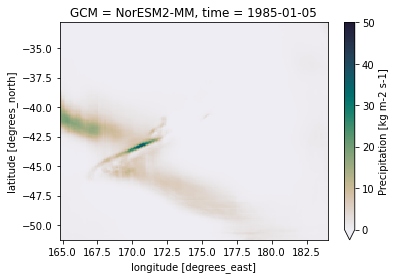

In [123]:
output_hist_reg_v4.isel(member =0, time =4).pr.plot(cmap ='cmo.rain', vmin =0, vmax =50)

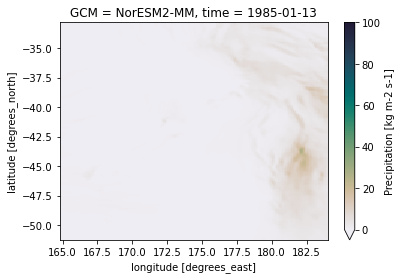

In [51]:
output_hist_v2.isel(member =4
, time =12).pr.plot(cmap ='cmo.rain', vmin =0, vmax =100)

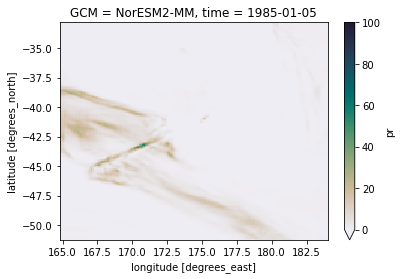

In [107]:
output_hist_v3.mean("member").isel(time =4).pr.plot(cmap ='cmo.rain', vmin =0, vmax =100)    

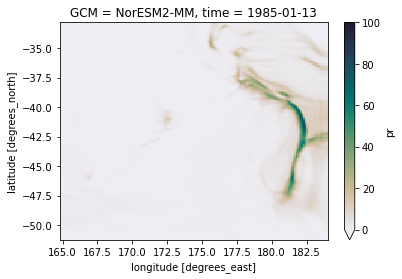

In [125]:
output_hist_v4.mean("member").isel(time =12).pr.plot(cmap ='cmo.rain', vmin =0, vmax =100)    

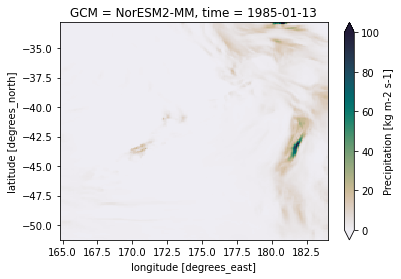

In [118]:
output_hist_v3.isel(member =1).isel(time =12).pr.plot(cmap ='cmo.rain', vmin =0, vmax =100) 

In [98]:
error_mean =(abs(output_hist_v3.mean("member") - y.sel(time = historical_period)*86400)**2)

In [99]:
error_mean.mean()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    GCM      <U10 'NorESM2-MM'
Data variables:
    pr       float64 56.67

In [128]:
error_mean =np.sqrt((abs(output_hist_v3.mean("member") - y.sel(time = historical_period)*86400)**2).mean("time"))
error_ense = np.sqrt(abs(output_hist_v3.mean("member") - output_hist_v3)**2).mean(["time","member"])

error_mean2 =np.sqrt((abs(output_hist_v2.mean("member") - y.sel(time = historical_period)*86400)**2).mean("time"))
error_ense2 = np.sqrt(abs(output_hist_v2.mean("member") - output_hist_v2)**2).mean(["time","member"])




In [138]:
error_mean3 =np.sqrt(abs(output_hist_v4.mean(["time","member"])- y.sel(time = historical_period).mean("time")*86400)**2)
error_ense3 = np.sqrt(abs(output_hist_v4.mean(["time","member"]) - output_hist_v4.mean("time"))**2).mean(["member"])

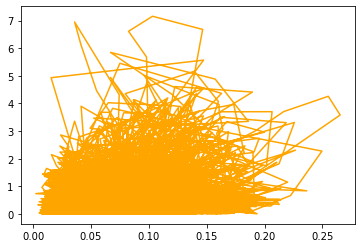

In [139]:
fig, ax = plt.subplots()
#ax.plot(error_ense.pr.values.ravel(), error_mean.pr.values.ravel(),'ro')
#ax.plot(error_ense2.pr.values.ravel(), error_mean2.pr.values.ravel(),'bo')
ax.plot(error_ense3.pr.values.ravel(), error_mean3.pr.values.ravel(),'orange')
#ax.plot(1.2 *error_ense2.pr.values.ravel(), 0.8* error_mean2.pr.values.ravel(),'bo')
#ax.plot([0,30], [0,30])

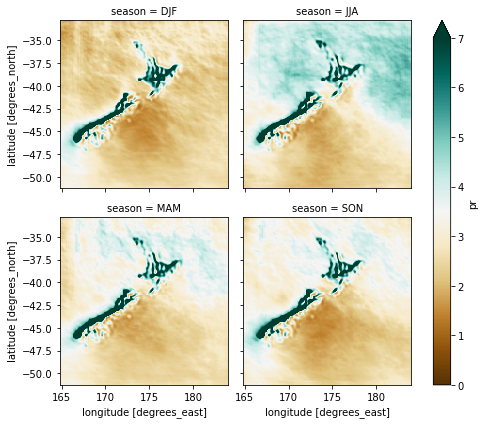

In [165]:
output_hist_v4.groupby('time.season').mean().pr.plot(col ="season", col_wrap =2, cmap ='BrBG', vmin =0, vmax =7)

In [166]:
climo_pred = output_hist_v4.groupby('time.season').mean()

In [176]:
climo_pred_reg = output_hist_reg_v4.groupby('time.season').mean()

In [167]:
climo_true = y.sel(time = historical_period).groupby('time.season').mean( ) *86400

In [177]:
error = abs(climo_pred - climo_true)
error_reg = abs(climo_pred_reg - climo_true)

In [178]:
error.mean(["lat","lon"])

<xarray.Dataset>
Dimensions:  (season: 4, member: 1)
Coordinates:
    GCM      <U10 'NorESM2-MM'
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: member
Data variables:
    pr       (season, member) float64 0.3494 0.57 0.6337 0.2973

In [179]:
error_reg.mean(["lat","lon"])

<xarray.Dataset>
Dimensions:  (season: 4, member: 1)
Coordinates:
    GCM      <U10 'NorESM2-MM'
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: member
Data variables:
    pr       (season, member) float64 1.118 1.755 1.667 1.096

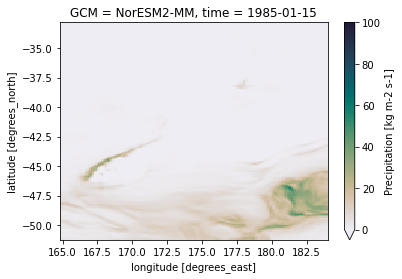

In [163]:
output_hist_v4.isel(
time =14).pr.plot(cmap ='cmo.rain', vmin =0, vmax =100)

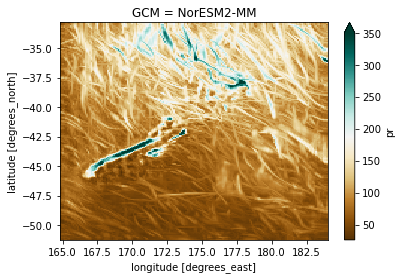

In [153]:
output_hist_v4.max("time").pr.mean("member").plot(cmap = 'BrBG', vmax =350)

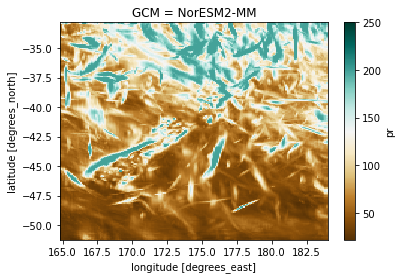

In [59]:
output_hist_v4_reg.clip(0, 300).max("time").pr.mean("member").plot(cmap = 'BrBG', vmax =250)

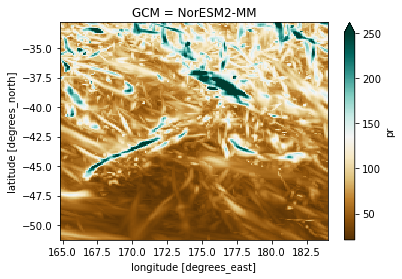

In [24]:
(y.sel(time = historical_period)*86400).max("time").pr.plot(cmap = 'BrBG', vmax =250)

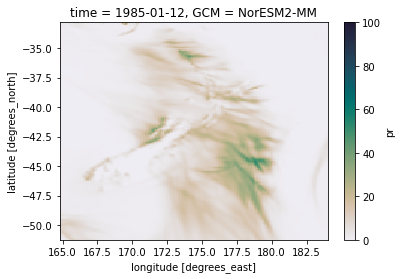

In [158]:
(y.sel(time = historical_period).isel(time =11)*3600*24).pr.plot(cmap ='cmo.rain', vmin =0, vmax =100)

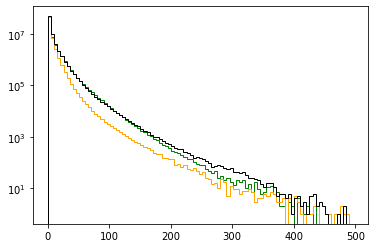

In [157]:
bins = np.arange(0.5, 500, 5)
#plt.hist(output_hist_v2.isel( member =1).pr.values.ravel(), histtype='step', bins = bins)
#plt.hist(output_hist_v3.isel( member =1).pr.values.ravel(), histtype='step', bins = bins)
plt.hist(output_hist_v4.isel( member =0).pr.values.ravel(), histtype='step', bins = bins, color ='g')
plt.hist(output_hist_reg_v4 .isel( member =0).pr.values.ravel(), histtype='step', bins = bins, color ='orange')
#plt.hist(output_hist.isel( member =2).pr.values.ravel(), histtype='step', bins = bins, color ='r')
#plt.hist(output_hist_reg_v2.isel( member =0).pr.values.ravel(), histtype='step', bins = bins, color ='orange')
plt.hist((y.sel(time = historical_period)*3600*24).pr.values.ravel(), histtype='step', bins = bins, color ='k')

plt.yscale('log')

In [91]:
z= (abs(output_hist.mean("member") - y.sel(time = historical_period)*3600*24)**2).mean()

In [90]:
z2= (abs(output_hist_reg.mean("member") - y.sel(time = historical_period)*3600*24)**2).mean()

In [93]:
z2

<xarray.Dataset>
Dimensions:  ()
Data variables:
    pr       float64 33.95

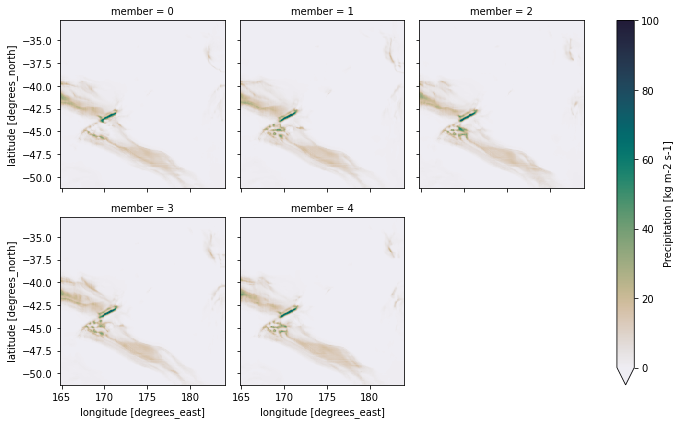

In [85]:
output_hist_v2.isel( time =4).pr.plot(cmap ='cmo.rain', vmin =0, vmax =100, col="member", col_wrap =3)